# Machine Learning - MSc 2024/2025

## Task 0 - Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde, spearmanr, chi2_contingency


### Loading Data

In [2]:
raw_df = pd.read_csv('./Data/PetFinder_dataset.csv', index_col='PetID')
print(raw_df.columns)
raw_df.drop(columns='Description').head() # hiding Description column for convenience

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PhotoAmt,AdoptionSpeed
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,...,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,1.0,2
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,2.0,0
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,...,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,7.0,3
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,...,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,8.0,2
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,...,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,3.0,2


In [3]:
# Checking Raw DF Description alone.
for PetID, Description in raw_df[['Description']].head().iterrows(): # using iterrows instead of iloc because we need access to the pair PetID: Description  
    print(f"<{PetID}> {Description.values[0]}")                  # iloc doesn't pair the Index with the data, instead only check the position.

<86e1089a3> Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.
<6296e909a> I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.
<3422e4906> Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.
<5842f1ff5> Good guard dog, very alert, active, obedience waiting for her good master, plz 

### Understanding Data

In [4]:
print("Is Index Unique: ", raw_df.index.is_unique)
print(raw_df.info())
# DF Shape: (14993, 23)
# Only "Name" and "Description" cols includes Null values
# Apart from non-numeric columns, the only that is considered float is "PhotoAmt"

Is Index Unique:  True
<class 'pandas.core.frame.DataFrame'>
Index: 14993 entries, 86e1089a3 to a83d95ead
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993

#### Creating Plotting Functions

In [5]:
def mybarplot(data, title, xlab, ylab, ax=None):
    counts = data.value_counts().sort_index()
    percentages = (counts / len(data)) * 100

    if ax is None:
        ax = plt.gca()

    bars = sns.barplot(x=counts.index, y=counts.values, color="skyblue", edgecolor="black", ax=ax)

    for bar, percentage in zip(bars.patches, percentages):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f'{percentage:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

def mycrosstab(var1, var2, title, xlab, ylab, leg, ax=None):
    ct_percentage = pd.crosstab(var1, var2, normalize='index') * 100

    if ax is None:
        ax = plt.gca()

    ct_percentage.plot(kind='bar', stacked=True, ax=ax)

    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.legend(title=leg, bbox_to_anchor=(1.05, 1), loc='upper left')

    return ct_percentage

def plot_side_by_side(data, var1, var2, 
                      barplot_title, barplot_xlab, barplot_ylab, 
                      crosstab_title, crosstab_xlab, crosstab_ylab, crosstab_leg):

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    mybarplot(data, title=barplot_title, xlab=barplot_xlab, ylab=barplot_ylab, ax=axes[0])
    ct_percentage = mycrosstab(var1, var2, title=crosstab_title, xlab=crosstab_xlab, ylab=crosstab_ylab, leg=crosstab_leg, ax=axes[1])
    plt.tight_layout()
    plt.show()
    print('\n', ct_percentage)

def mychi2(var1, var2):
    chi2, pval, dof, _ = chi2_contingency(pd.crosstab(var1, var2))
    print("\nTeste de Independência do Qui-Quadrado:")
    print("Hipótese Nula: As duas variáveis são independentes")
    print("Hipótese Alternativa: As duas variáveis não são independentes")
    print(f"Estatística de Teste: {chi2:.4f}")
    print(f"valor-p: {pval:.4f}")
    print(f"Graus de Liberdade: {dof}")

#### Checking Features Unique Values

`Here we can observe the top 5 unique values for each column.`

By doing this we can get a quick general idea of how our data is distributed, as well as some interesting details like:
1. There are more dogs then cats for adoption
2. The most used pet names are "Baby" and "Lucky"
3. The id of the rescuer with the most rescues (459)
4. The most common Primary colour among pets is Black followed by Brown

In [6]:
# Top 5 most common unique values for each feature.
for column in raw_df.columns:
    print(raw_df[column].value_counts().head(5))

Type
1    8132
2    6861
Name: count, dtype: int64
Name
Baby       66
Lucky      64
No Name    54
Brownie    54
Mimi       52
Name: count, dtype: int64
Age
2     3503
1     2304
3     1966
4     1109
12     967
Name: count, dtype: int64
Breed1
307    5927
266    3634
265    1258
299     342
264     296
Name: count, dtype: int64
Breed2
0      10762
307     1727
266      599
265      321
299      138
Name: count, dtype: int64
Gender
2    7277
1    5536
3    2180
Name: count, dtype: int64
Color1
1    7427
2    3750
3     947
5     884
6     684
Name: count, dtype: int64
Color2
0    4471
7    3438
2    3313
5    1128
6    1063
Name: count, dtype: int64
Color3
0    10604
7     3221
5      417
6      378
4      198
Name: count, dtype: int64
MaturitySize
2    10305
1     3395
3     1260
4       33
Name: count, dtype: int64
FurLength
1    8808
2    5361
3     824
Name: count, dtype: int64
Vaccinated
2    7227
1    5898
3    1868
Name: count, dtype: int64
Dewormed
1    8397
2    4815
3    1781


`Here we can observe the ammount of unique values for each feature`

As is preferable to have a simpler model rather then a complex one, we are looking at the ammount of unique values each features has to see if we should consider trying to simplify or remove altogether before advancing to our predictions.

We can observe that features such as Name, RescuerID and Description have a lot of values to account for. Given the context of our task and that none of these features are numerical variables we figured the value they are adding doesn't make up for the complexity of including them. Because of this, all "Name", "RescuerID" and "Description" should be promptly disposed.

Additionally we can also observe some features that could possibly benefit from some simplification but that are much more managable and relevant given the context, such as Breed 1/2, Fee and Age.

In [7]:
# Checking for the ammount of unique values for each feature.
for column in raw_df.columns:
    print(f"{column}: {len(raw_df[column].unique())} Unique Values")

Type: 2 Unique Values
Name: 9060 Unique Values
Age: 106 Unique Values
Breed1: 176 Unique Values
Breed2: 135 Unique Values
Gender: 3 Unique Values
Color1: 7 Unique Values
Color2: 7 Unique Values
Color3: 6 Unique Values
MaturitySize: 4 Unique Values
FurLength: 3 Unique Values
Vaccinated: 3 Unique Values
Dewormed: 3 Unique Values
Sterilized: 3 Unique Values
Health: 3 Unique Values
Quantity: 19 Unique Values
Fee: 74 Unique Values
State: 14 Unique Values
RescuerID: 5595 Unique Values
VideoAmt: 9 Unique Values
Description: 14032 Unique Values
PhotoAmt: 31 Unique Values
AdoptionSpeed: 5 Unique Values


#### Checking Target Feature - Adoption Speed

0. Adopted within the first day: 2.7%
1. Adopted Within the first week: 20.6%
2. Adopted within the first month: 26.9%
3. Adopted withing the 2nd/3rd month: 21.7%
4. Not adopted after 100+ days: 28.0%

This feature presents some class imbalance as class 0 represents > 3% of all profiles while all others are no lower then 20%.

Additionally we can observe a proportion of 72:100 of profiles that were adopted before the 100 days mark.

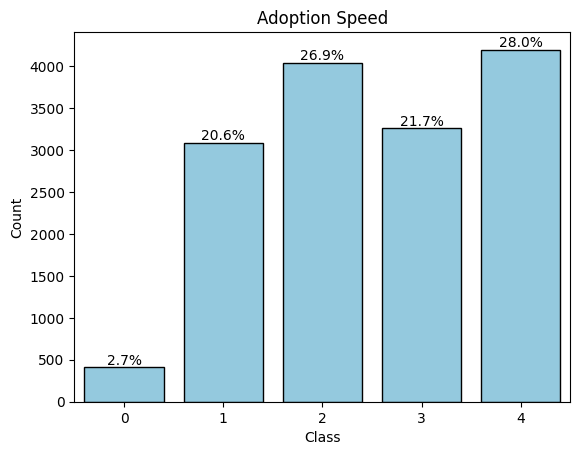

In [8]:
mybarplot(data = raw_df['AdoptionSpeed'], title = "Adoption Speed", xlab = "Class", ylab = "Count", ax=None)

#### Checking Other Features Distributions By Adoption Speed

##### Type

There is a good balance regarding the ammount of dogs vs cats in our data.

Additionally we can observe that cats have a better probability of being adopted, this also extends across the speed of adoption.

We can also conclude that the type present statistical significance as we can confidently distard *H0*

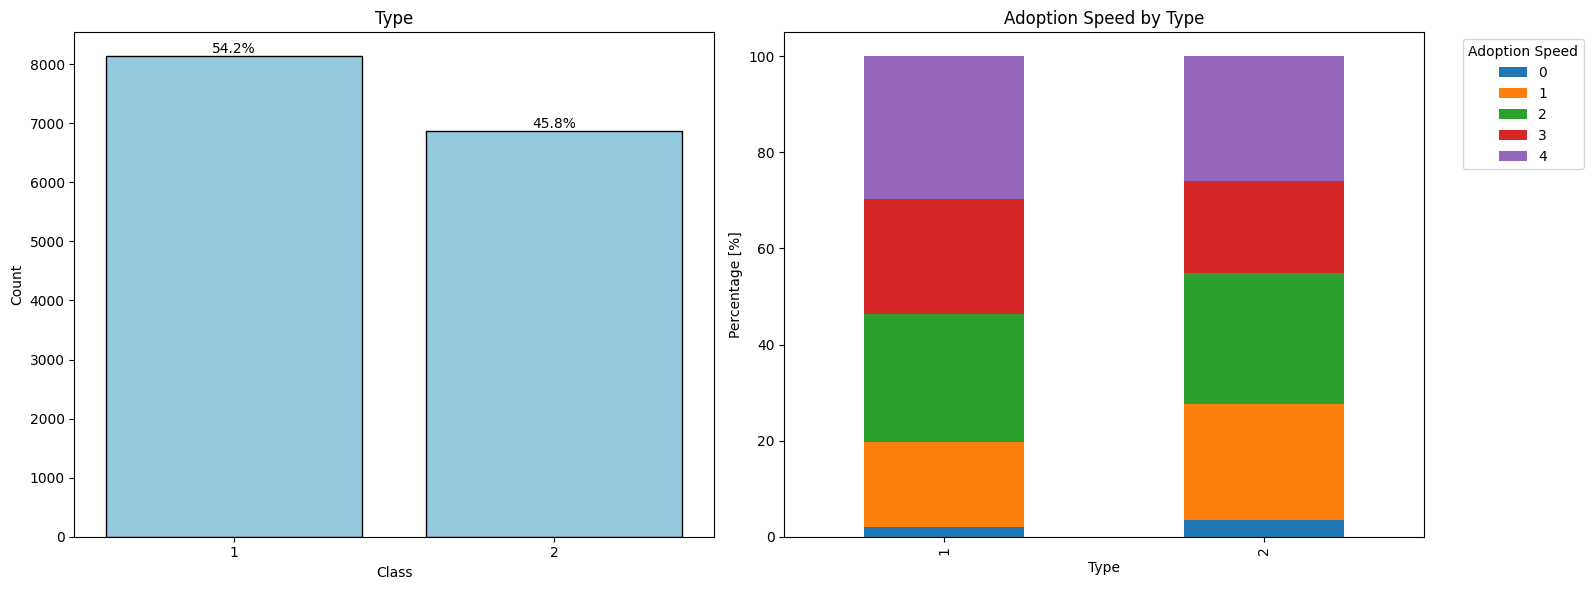


 AdoptionSpeed         0          1          2          3          4
Type                                                               
1              2.090507  17.646335  26.610920  23.967044  29.685194
2              3.498032  24.121848  27.299228  19.093427  25.987465

Teste de Independência do Qui-Quadrado:
Hipótese Nula: As duas variáveis são independentes
Hipótese Alternativa: As duas variáveis não são independentes
Estatística de Teste: 162.1682
valor-p: 0.0000
Graus de Liberdade: 4


In [9]:
plot_side_by_side(
    data=raw_df['Type'],
    var1=raw_df['Type'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Type",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Type",
    crosstab_xlab="Type",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

mychi2(var1 = raw_df["Type"], var2 = raw_df["AdoptionSpeed"])

##### Age

- Age = 0 probably means the pet is > 1 month old.
- The oldest pet is 21 years old, which is possible although extremely unlikely.
- About 75% of pets are less then a year old.
- We can observe that the probability of adoption as well as the adoption speed diminish as the pets grow older. Interestingly, profiles with 36+ months get a pump in adoption probability, however this could be due to a smaller sample size.

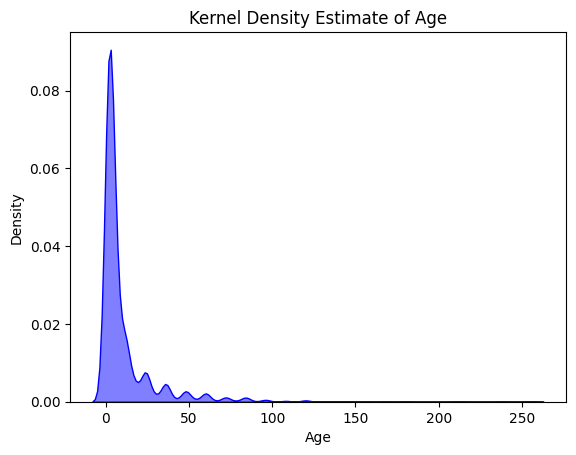

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64


In [10]:
sns.kdeplot(raw_df["Age"], fill=True, color='blue', alpha=0.5)
plt.title("Kernel Density Estimate of Age")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

print(raw_df['Age'].describe())

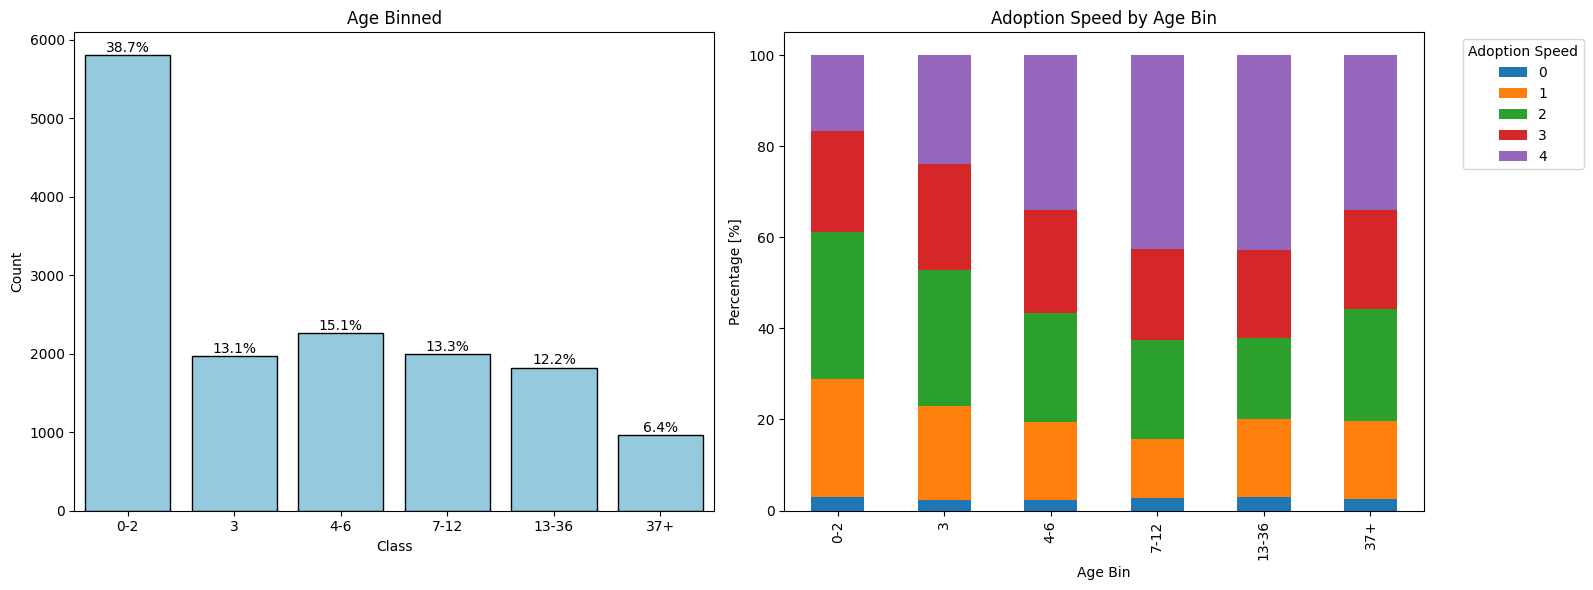


 AdoptionSpeed         0          1          2          3          4
AgeBinned                                                          
0-2            2.910281  25.968659  32.271397  22.283451  16.566213
3              2.238047  20.752798  29.806714  23.296033  23.906409
4-6            2.254642  17.285588  23.828470  22.546419  34.084881
7-12           2.804206  12.919379  21.632449  20.030045  42.613921
13-36          3.070175  17.050439  17.817982  19.243421  42.817982
37+            2.505219  17.118998  24.739040  21.607516  34.029228


In [11]:
bins = [0, 2, 3, 6, 12, 36, float('inf')]
labels = ['0-2', '3', '4-6', '7-12', '13-36', '37+']
raw_df['AgeBinned'] = pd.cut(raw_df['Age'], bins=bins, labels=labels, right=True)

plot_side_by_side(
    data=raw_df['AgeBinned'],
    var1=raw_df['AgeBinned'],
    var2=raw_df['AdoptionSpeed'],
    barplot_title="Age Binned",
    barplot_xlab="Class",
    barplot_ylab="Count",
    crosstab_title="Adoption Speed by Age Bin",
    crosstab_xlab="Age Bin",
    crosstab_ylab="Percentage [%]",
    crosstab_leg="Adoption Speed"
)

##### Breed

Breed feature is split across Breed 1 and 2.


# Keep this format? Can you guys continue up? 

#### Checking Feature Importance

In [12]:
# setting variable types for each feature.
nominal_data = ['Type', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'Vaccinated', 'Dewormed', 'Sterilized', 'State']
discrete_data = ['Age', 'Quantity', 'VideoAmt', 'PhotoAmt']
ordinal_data = ['MaturitySize', 'FurLength', 'Health']
continuous_data= ['Fee']


- Nominal Data

We can see that for all nominal data, all p-values are low and that the only feature we could consider removing due to not being statistically significant would be the Color3
- Discrete Data

Although correlations are low, `Age` present a positive correlation of 0.2 and the only feature with a p-value above 5% is VideoAmt.
- Ordinal Data

Ordinal features present an overall low correlation. `FurLength` is relatively interesting. All other have low enough p-values to be considered but don't present interesting correlation.

- Continuous Data

`Fee` feature presents a relatively high p-value when compared with other features. Additionally it also shows a low correlation.

In [13]:
# Chi2 test for nominal vars, lower p-value means higher association
for col in nominal_data:
    contingency_table = pd.crosstab(raw_df[col], raw_df['AdoptionSpeed'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Feature: {col}, Chi-Square p-value: {p}")

Feature: Type, Chi-Square p-value: 5.010488338487473e-34
Feature: Breed1, Chi-Square p-value: 1.3016781691537534e-64
Feature: Breed2, Chi-Square p-value: 4.692941104124828e-24
Feature: Color1, Chi-Square p-value: 4.3164323355943933e-10
Feature: Color2, Chi-Square p-value: 3.277005829316167e-07
Feature: Color3, Chi-Square p-value: 0.06161131317368764
Feature: Gender, Chi-Square p-value: 1.8710135257210012e-13
Feature: Vaccinated, Chi-Square p-value: 1.38085739169085e-56
Feature: Dewormed, Chi-Square p-value: 5.48680712443291e-28
Feature: Sterilized, Chi-Square p-value: 3.324332821585669e-166
Feature: State, Chi-Square p-value: 7.304960081191035e-38


In [14]:
# Spearman correlation for discrete features
for col in discrete_data:
    corr, p_value = spearmanr(raw_df[col], raw_df['AdoptionSpeed'])
    print(f"Feature: {col}, Spearman Correlation: {corr}, p-value: {p_value}")

Feature: Age, Spearman Correlation: 0.20952947524534685, p-value: 2.217735149394727e-148
Feature: Quantity, Spearman Correlation: 0.05348888668892989, p-value: 5.615098369514659e-11
Feature: VideoAmt, Spearman Correlation: -0.011440018594433473, p-value: 0.16130006723618878
Feature: PhotoAmt, Spearman Correlation: -0.061918936705867345, p-value: 3.2395536463752547e-14


In [15]:
# Spearman correlation for ordinal features
for col in ordinal_data:
    corr, p_value = spearmanr(raw_df[col], raw_df['AdoptionSpeed'])
    print(f"Feature: {col}, Spearman Correlation: {corr}, p-value: {p_value}")

Feature: MaturitySize, Spearman Correlation: 0.05004100649409911, p-value: 8.75227905692494e-10
Feature: FurLength, Spearman Correlation: -0.07982354723759089, p-value: 1.2568770320502083e-22
Feature: Health, Spearman Correlation: 0.028375030737680454, p-value: 0.0005112033394091628


In [16]:
# Spearman correlation for continuous features
corr, p_value = spearmanr(raw_df['Fee'], raw_df['AdoptionSpeed'])
print(f"Feature: {'Fee'}, Spearman Correlation: {corr}, p-value: {p_value}")

Feature: Fee, Spearman Correlation: 0.018479024890036732, p-value: 0.023655084338629225


In [17]:
non_nominal_data = ['Age', 'Quantity', 'VideoAmt', 'PhotoAmt', 'Fee', 'MaturitySize', 'FurLength', 'Health']

# setting variable types for each feature.
nominal_data = ['Type', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'Vaccinated', 'Dewormed', 'Sterilized', 'State', 'isPetAdopted', 'isPureBreed']

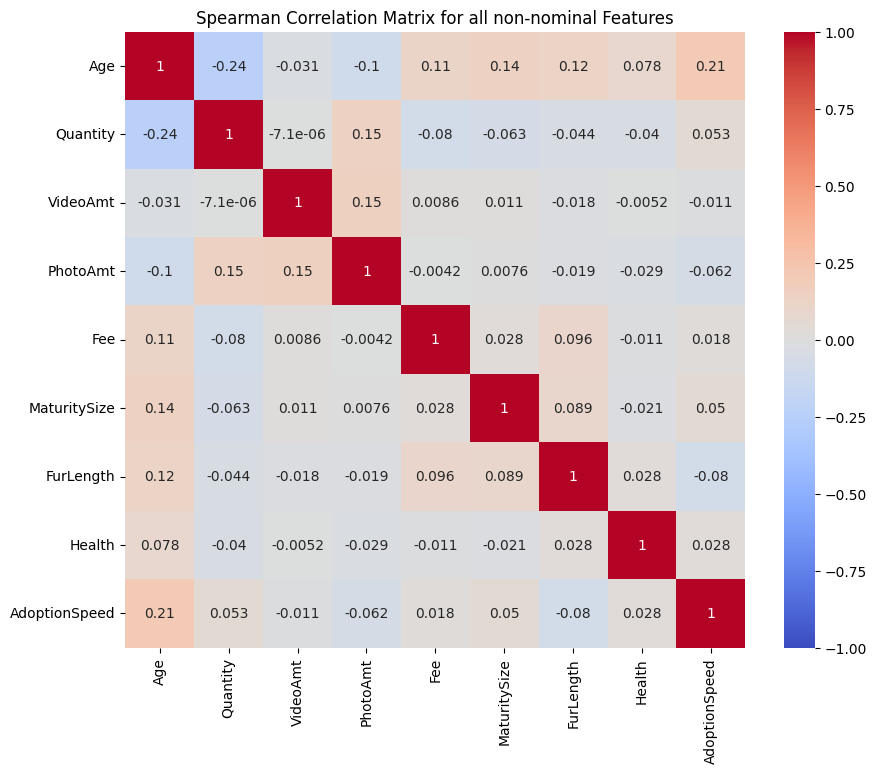

In [18]:
data = raw_df[non_nominal_data + ['AdoptionSpeed']]

correlation_matrix = data.corr(method='spearman')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True, vmin=-1, vmax=1)
plt.title("Spearman Correlation Matrix for all non-nominal Features")
plt.show()

### Feature Engineering and Preprocessing